This notebook generates the figures for Chapter 2: Image Processing from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [164]:
import os,sys,shutil
from wand.image import Image as WImage
import numpy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel
from nilearn.input_data import NiftiMasker
import nilearn.image

# set up rpy2 so we can use R magic
%load_ext rpy2.ipython

sys.path.append('../../utils')
from get_data import get_data

data=get_data()
datadir=os.path.dirname(data['T1'])
figuredir='../../figures'
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


__Figure 2.1:__ Generated manually for previous edition, use as is.

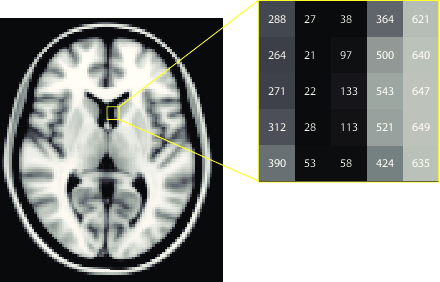

In [165]:
WImage(filename='/Users/poldrack/Dropbox/Documents/Books/HandbookOfFMRIAnalysis/fmri-handbook-2e/figures/Figure_2_1.pdf')

__Figure 2.2:__ Generated manually for previous edition, use as is.

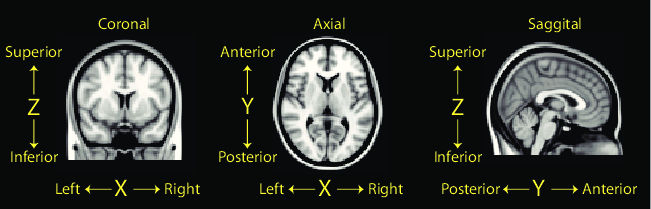

In [166]:
WImage(filename='/Users/poldrack/Dropbox/Documents/Books/HandbookOfFMRIAnalysis/fmri-handbook-2e/figures/Figure_2_2.pdf')

__Figure 2.3:__ Examples of linear transforms

In [167]:
# set up 4 X 1 homogenous coordinate matrix
# see http://bishopw.loni.ucla.edu/AIR5/homogenous.html

# first create coordinates
coords=numpy.ones((4,16))
coords[2,:]=1
coords[0,:]=numpy.kron(numpy.arange(4),numpy.ones((1,4)))-1.5
coords[1,:]=numpy.kron(numpy.ones((1,4)),numpy.arange(4))-1.5

In [168]:
# show the original and transformed coordinates
# First define some functions to show the coordinates and lines

def plot_coord_lines(coordinates,color):
    for i in numpy.arange(0,16,4):
        plt.plot([coordinates[0,i],coordinates[0,i+3]],[coordinates[1,i],coordinates[1,i+3]],color=color)
    for i in range(4):
        plt.plot([coordinates[0,i],coordinates[0,i+12]],[coordinates[1,i],coordinates[1,i+12]],color=color)

def show_coords(c,ct,label,plot_lines=True):
    plt.scatter(c[0,:],c[1,:],color='black')
    plot_coord_lines(c,'black')
    plt.axis([-3,3,-3,3])
    plt.scatter(ct[0,:],ct[1,:],color='blue')
    if plot_lines:
        plot_coord_lines(ct,'blue')
    plt.title(label,fontsize=18)
    plt.xticks([])
    plt.yticks([])
    


In [169]:
# translation

xtrans=0.5;
ytrans=0.2;
ztrans=0;
translation_matrix=numpy.eye(4)
translation_matrix[:3,3]=numpy.array([xtrans,ytrans,ztrans]).T

coords_translated=numpy.zeros(coords.shape)
for x in range(16):
        coords_translated[:,x] = translation_matrix.dot(coords[:,x])


# rotation
from numpy import cos,sin
xrot=0 # pitch
yrot=0 # roll
zrot=numpy.pi/8. # yaw

coords_rotated=numpy.zeros(coords.shape)
rotation_matrix=numpy.eye(4)
rotation_matrix[:3,0]=[cos(zrot)*cos(yrot)+sin(zrot)*sin(xrot)*sin(yrot),
                        -1*sin(zrot)*cos(xrot),
                        sin(zrot)*sin(xrot)*cos(yrot)-cos(zrot)*sin(yrot)]
rotation_matrix[:3,1]=[sin(zrot)*cos(yrot)-cos(zrot)*sin(xrot)*sin(yrot),
                        cos(zrot)*cos(xrot),
                        -1*cos(zrot)*sin(xrot)*cos(yrot)-sin(zrot)*sin(yrot)]
rotation_matrix[:3,2]=[cos(xrot)*sin(yrot), sin(xrot),cos(xrot)*cos(yrot)]

for x in range(16):
    coords_rotated[:,x] = rotation_matrix.dot(coords[:,x])

# rescaling

scaling_matrix=numpy.eye(4)
scaling_matrix[0,0]=1.2 # x scale
scaling_matrix[1,1]=1.1 # y scale
scaling_matrix[2,2]=1 # z scale
coords_scaled=numpy.zeros(coords.shape)
for x in range(16):
    coords_scaled[:,x] = scaling_matrix.dot(coords[:,x])

# skewing/shearing
# method suggested by Ashburner & Friston in HBF chapter:

xshear=0;
yshear=0.5;
zshear=0;
shear_matrix=numpy.eye(4);
shear_matrix[1,0]=0.5 # yshear
coords_sheared=numpy.zeros(coords.shape)
for x in range(16):
    coords_sheared[:,x] = shear_matrix.dot(coords[:,x])


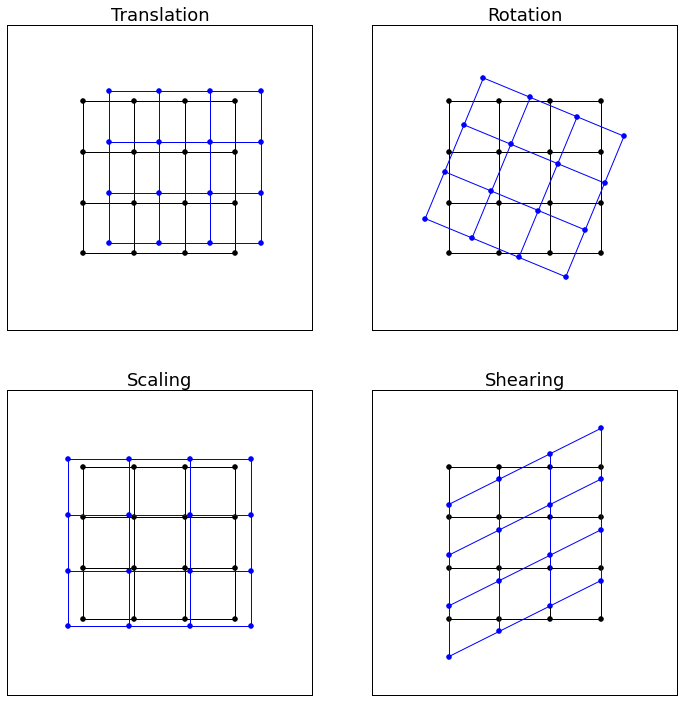

In [170]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
show_coords(coords,coords_translated,'Translation')
plt.subplot(2,2,2)
show_coords(coords,coords_rotated,'Rotation',plot_lines=True)
plt.subplot(2,2,3)
show_coords(coords,coords_scaled,'Scaling',plot_lines=True)
plt.subplot(2,2,4)
show_coords(coords,coords_sheared,'Shearing',plot_lines=True)
plt.savefig(os.path.join(figuredir,'Figure_2_3.svg'),format='svg',dpi=1200)

__Figure 2.4__: Examples of different types of MRI images

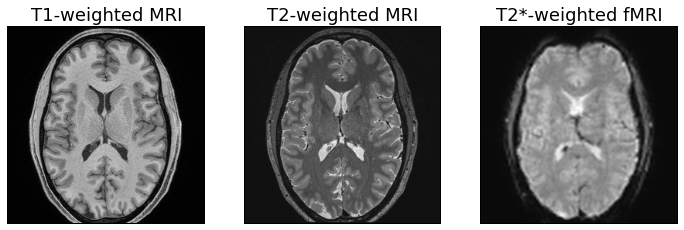

In [171]:
slicenum=150
t1bcdata=nibabel.load(data['T1_bc']).get_data()
t2data=nibabel.load(data['T2_reg2T1']).get_data()
epidata=nibabel.load(data['func_reg_to_t1']).get_data()
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(numpy.rot90(t1bcdata[:,:,slicenum]),cmap='gray')
plt.title('T1-weighted MRI',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(numpy.rot90(t2data[:,:,slicenum]),cmap='gray')
plt.title('T2-weighted MRI',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(numpy.rot90(epidata[:,:,slicenum]),cmap='gray')
plt.title('T2*-weighted fMRI',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(figuredir,'Figure_2_4.svg'),format='svg',dpi=1200)

__Figure 2.5:__ Joint histogram of T1-weighted and T2-weighted images.

In [172]:
t1masker=NiftiMasker(mask_img=data['T1_brainmask'])
t1data=t1masker.fit_transform(data['T1_bc']).ravel()
t2data=t1masker.fit_transform(data['T2_reg2T1']).ravel()
t2data[t2data<0]=0

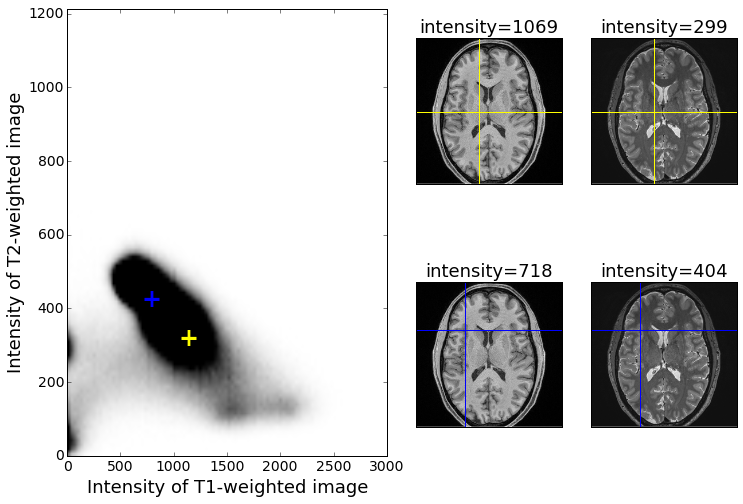

In [223]:
plt.figure(figsize=(12,8))
jointhist,x,y=numpy.histogram2d(t1data,t2data, bins=100,normed=True)
ax1 = plt.subplot2grid((2,4), (0,0), rowspan=2,colspan=2)
plot=plt.imshow(1-jointhist,cmap='gray',vmin=0.999999,vmax=1.0,
          extent=[numpy.min(x),numpy.max(x),numpy.min(y),numpy.max(y)],
          aspect='auto',origin='lower')
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Intensity of T1-weighted image',fontsize=18)
plt.ylabel('Intensity of T2-weighted image',fontsize=18)

t1imgdata=nibabel.load(data['T1_bc']).get_data()
t2imgdata=nibabel.load(data['T2_reg2T1']).get_data()

coord1=[110,130]
coord2=[85,85]
plt.text(t1imgdata[t1imgdata.shape[0]-coord1[0],t1imgdata.shape[1]-coord1[1],150],
                   t2imgdata[t2imgdata.shape[0]-coord1[0],t2imgdata.shape[1]-coord1[1],150],
                             '+',color='yellow',size=24,weight='bold')

plt.text(t1imgdata[t1imgdata.shape[0]-coord2[0],t1imgdata.shape[1]-coord2[1],150],
                   t2imgdata[t2imgdata.shape[0]-coord2[0],t2imgdata.shape[1]-coord2[1],150],
                             '+',color='blue',size=24,weight='bold')


ax2 = plt.subplot2grid((2,4), (0,2))
plt.imshow(numpy.rot90(t1imgdata[:,:,150]),cmap='gray')
plt.title('intensity=%d'%t1imgdata[t1imgdata.shape[0]-coord1[0],t1imgdata.shape[1]-coord1[1],150],fontsize=18)
plt.xticks([])
plt.yticks([])
plt.plot([0,t1imgdata.shape[0]],[coord1[1],coord1[1]],color='yellow')
plt.plot([coord1[0],coord1[0]],[0,t1imgdata.shape[1]],color='yellow')
ax3 = plt.subplot2grid((2,4), (0,3))
plt.imshow(numpy.rot90(t2imgdata[:,:,150]),cmap='gray')
plt.title('intensity=%d'%t2imgdata[t2imgdata.shape[0]-coord1[0],t2imgdata.shape[1]-coord1[1],150],fontsize=18)
plt.xticks([])
plt.yticks([])
plt.plot([0,t1imgdata.shape[0]],[coord1[1],coord1[1]],color='yellow')
plt.plot([coord1[0],coord1[0]],[0,t1imgdata.shape[1]],color='yellow')

ax3 = plt.subplot2grid((2,4), (1,2))
plt.imshow(numpy.rot90(t1imgdata[:,:,150]),cmap='gray')
plt.title('intensity=%d'%t1imgdata[t1imgdata.shape[0]-coord2[0],t1imgdata.shape[1]-coord2[1],150],fontsize=18)
plt.xticks([])
plt.yticks([])
plt.plot([0,t1imgdata.shape[0]],[coord2[1],coord2[1]],color='blue')
plt.plot([coord2[0],coord2[0]],[0,t1imgdata.shape[1]],color='blue')
ax4 = plt.subplot2grid((2,4), (1,3))
plt.imshow(numpy.rot90(t2imgdata[:,:,150]),cmap='gray')
plt.title('intensity=%d'%t2imgdata[t2imgdata.shape[0]-coord2[0],t2imgdata.shape[1]-coord2[1],150],fontsize=18)
plt.xticks([])
plt.yticks([])
plt.plot([0,t1imgdata.shape[0]],[coord2[1],coord2[1]],color='blue')
plt.plot([coord2[0],coord2[0]],[0,t1imgdata.shape[1]],color='blue')


__Figure 2.6__: Joint histogram for original and rotated images

INFO:interface:stdout 2015-09-08T15:56:06.296006:WARNING:: Flipping Left/Right orientation (as det < 0)


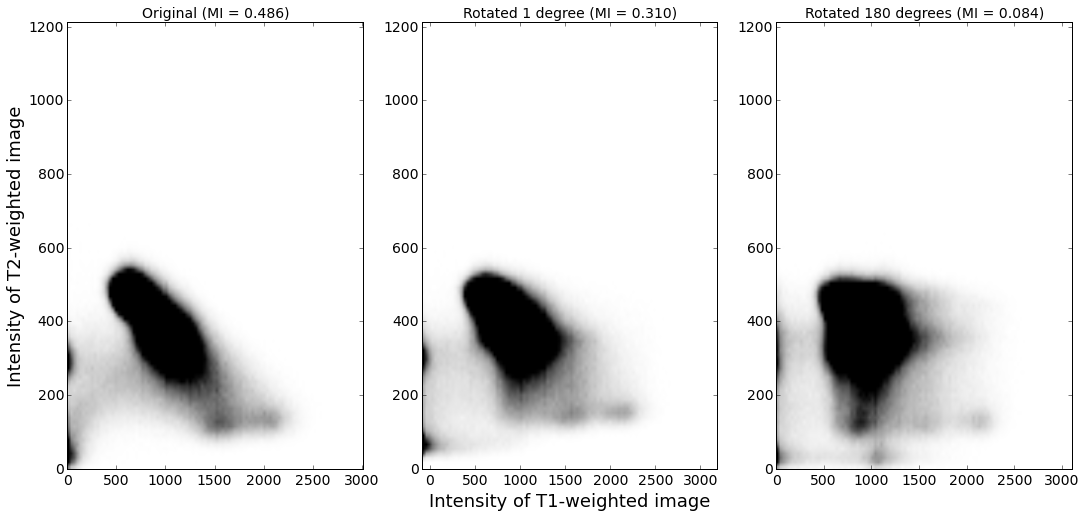

In [240]:
def calc_MI(x, y, bins=25):
    # compute mutual information between two variables
    import sklearn.metrics
    c_xy = numpy.histogram2d(x, y, bins)[0]
    mi = sklearn.metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi

vmin=0.999999

jointhist,x,y=numpy.histogram2d(t1data,t2data, bins=100,normed=True)

plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plot=plt.imshow(1-jointhist,cmap='gray',vmin=vmin,vmax=1.0,
          extent=[numpy.min(x),numpy.max(x),numpy.min(y),numpy.max(y)],
          aspect='auto',origin='lower')
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('Intensity of T2-weighted image',fontsize=18)
plt.title('Original (MI = %0.3f)'%calc_MI(t1data,t2data),fontsize=14)

rotation_matrix=numpy.eye(4)
angle=0.01 # radians
rotation_matrix[0,0]=numpy.cos(angle)
rotation_matrix[1,1]=numpy.cos(angle)
rotation_matrix[1,0]=numpy.sin(angle)
rotation_matrix[0,1]=-1*numpy.sin(angle)
numpy.savetxt('/tmp/rotmat_0.01.txt',rotation_matrix)


applyxfm=fsl.ApplyXfm()

if not os.path.exists('/tmp/t1_rot_01.nii.gz'):
    applyxfm.inputs.in_file =data['T1_bc']
    applyxfm.inputs.in_matrix_file = '/tmp/rotmat_0.01.txt'
    applyxfm.inputs.out_file = '/tmp/t1_rot_01.nii.gz'
    applyxfm.inputs.reference = data['T1_bc']
    applyxfm.inputs.apply_xfm = True
    result = applyxfm.run() 

t1data_rot01=t1masker.fit_transform('/tmp/t1_rot_01.nii.gz').ravel()

jointhist,x,y=numpy.histogram2d(t1data_rot01,t2data, bins=100,normed=True)
plt.subplot(1,3,2)
plot=plt.imshow(1-jointhist,cmap='gray',vmin=vmin,vmax=1.0,
          extent=[numpy.min(x),numpy.max(x),numpy.min(y),numpy.max(y)],
          aspect='auto',origin='lower')
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Intensity of T1-weighted image',fontsize=18)
plt.title('Rotated 1 degree (MI = %0.3f)'%calc_MI(t1data_rot01,t2data),fontsize=14)

if not os.path.exists('/tmp/t1_rot180.nii.gz'):
    from nipype.interfaces.fsl.utils import SwapDimensions
    swapdim=SwapDimensions(new_dims=('x','-y','z'))
    swapdim.inputs.in_file=data['T1_bc']
    swapdim.inputs.out_file = '/tmp/t1_rot_180.nii.gz'
    result = swapdim.run() 

t1data_rot180=t1masker.fit_transform('/tmp/t1_rot_180.nii.gz').ravel()

jointhist,x,y=numpy.histogram2d(t1data_rot180,t2data, bins=100,normed=True)
plt.subplot(1,3,3)
plot=plt.imshow(1-jointhist,cmap='gray',vmin=vmin,vmax=1.0,
          extent=[numpy.min(x),numpy.max(x),numpy.min(y),numpy.max(y)],
          aspect='auto',origin='lower')
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title('Rotated 180 degrees (MI = %0.3f)'%calc_MI(t1data_rot180,t2data),fontsize=14)


__Figure 2.7__: Effects of regularization on normalization

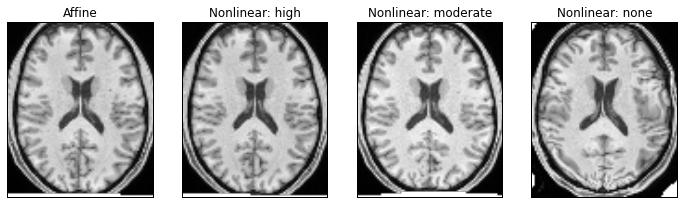

In [112]:
import nipype.interfaces.spm as spm
from nipype.caching import Memory
mem = Memory(base_dir='.')

# make an uncompressed version for use with sp
t1bc=nibabel.load(data['T1_bc'])
t1bc.to_filename('/tmp/t1bc.nii')

plt.figure(figsize=(12,6))
slicenum=44
spm_reg = mem.cache(spm.Normalize)

if not os.path.exists(os.path.join(datadir,'spm_affinereg.nii')):
    spm_reg_results = spm_reg(source='/tmp/t1bc.nii',
                        template='/Applications/fmri_progs/spm12/canonical/avg152T1.nii',
                        nonlinear_iterations=0)
    shutil.copy(spm_reg_results.outputs.normalized_source,
                    os.path.join(datadir,'spm_affinereg.nii'))
plt.subplot(1,4,1)
affinedata=nibabel.load(os.path.join(datadir,'spm_affinereg.nii')).get_data()
plt.imshow(numpy.rot90(affinedata[:,:,slicenum]),cmap='gray')
plt.title('Affine')
plt.xticks([])
plt.yticks([])
ctr=2
regularization_text={100:'high',1:'moderate',0:'none'}
for regularization in [100,1,0]:
    if not os.path.exists(os.path.join(datadir,'spm_nonlinreg%d.nii'%regularization)):
        spm_reg_results = spm_reg(source='/tmp/t1bc.nii',
                        template='/Applications/fmri_progs/spm12/canonical/avg152T1.nii',
                        nonlinear_regularization=regularization)
        shutil.copy(spm_reg_results.outputs.normalized_source,
                    os.path.join(datadir,'spm_nonlinreg%d.nii'%regularization))
    plt.subplot(1,4,ctr)
    ctr+=1
    regdata=nibabel.load(os.path.join(datadir,'spm_nonlinreg%d.nii'%regularization)).get_data()
    plt.imshow(numpy.rot90(regdata[:,:,slicenum]),cmap='gray')
    plt.title('Nonlinear: %s'%regularization_text[regularization])
    plt.xticks([])
    plt.yticks([])
    
os.remove('/tmp/t1bc.nii')
plt.savefig(os.path.join(figuredir,'Figure_2_7.svg'),format='svg',dpi=1200)

__Figure 2.8__: Example of downsampling

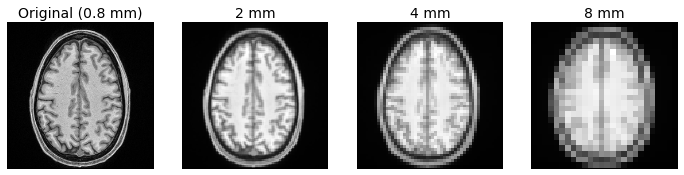

In [156]:
import nipype.interfaces.fsl as fsl
slicenum=150
origpixdims=t1bc.get_header().get_zooms()
origdims=t1bc.get_shape()
fig=plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
plt.imshow(numpy.rot90(t1bcdata[:,:,numpy.round(slicenum/origpixdims[0])]),cmap='gray')
plt.title('Original (0.8 mm)',fontsize=14)
plt.xticks([])
plt.yticks([])
ctr=2
applyxfm=fsl.ApplyXfm()

for i in [2,4,8]:
    # first make an image of the appropriate shape
    newdims=numpy.round(numpy.array(origdims)*(numpy.array(origpixdims)/float(i)))
    affine=numpy.eye(4)
    for x in range(3):
        affine[x,x]=i
    newimg=nibabel.Nifti1Image(numpy.zeros(newdims),affine)
    newimg.to_filename('/tmp/newimg.nii.gz')
    applyxfm.inputs.in_file =data['T1_bc']
    applyxfm.inputs.in_matrix_file = os.path.join(os.getenv('FSLDIR'),'etc/flirtsch/ident.mat')
    applyxfm.inputs.out_file = '/tmp/resample%d.nii.gz'%i
    applyxfm.inputs.reference = '/tmp/newimg.nii.gz'
    applyxfm.inputs.apply_xfm = True
    result = applyxfm.run() 
    newimg=nibabel.load(applyxfm.inputs.out_file).get_data()
#    newimg=nilearn.image.resample_img(t1bc,target_shape=newdims,
#target_affine=affine)
#    newimg.to_filename('test%d.nii.gz'%i)
#    newimgdata=newimg.get_data()
    plt.subplot(1,4,ctr)
    ctr+=1
    plt.imshow(numpy.rot90(newimg[:,:,numpy.round(slicenum/i)]),cmap='gray',interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title('%d mm'%i,fontsize=14)
    
plt.savefig(os.path.join(figuredir,'Figure_2_8.svg'),format='svg',dpi=1200)

0.0

__Figure 2.9__: Effects of interpolation

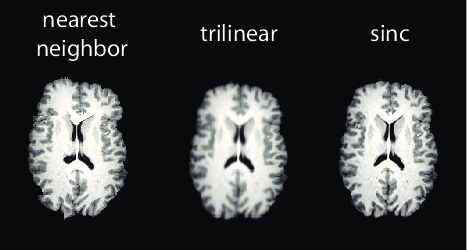

In [13]:
WImage(filename='/Users/poldrack/Dropbox/Documents/Books/HandbookOfFMRIAnalysis/fmri-handbook-2e/figures/Figure_2_9.pdf')

In [160]:
rotation_matrix=numpy.eye(4)
angle=0.01 # radians
rotation_matrix[0,0]=numpy.cos(angle)
rotation_matrix[1,1]=numpy.cos(angle)
rotation_matrix[1,0]=numpy.sin(angle)
rotation_matrix[0,1]=-1*numpy.sin(angle)

numpy.savetxt('/tmp/rotmat.txt',rotation_matrix)
applyxfm=fsl.ApplyXfm()

for i in range(6):
    for interp in ['trilinear','nearestneighbour','sinc']:
        print i,interp
        outfile='/tmp/rotation_%s_%d.nii.gz'%(interp,i)
        if i==0:
            infile=data['T1_bc']
        else:
            infile='/tmp/rotation_%s_%d.nii.gz'%(interp,i-1)
        
        applyxfm.inputs.in_file =infile
        applyxfm.inputs.in_matrix_file = '/tmp/rotmat.txt'
        applyxfm.inputs.out_file = outfile
        applyxfm.inputs.reference = data['T1_bc']
        applyxfm.inputs.apply_xfm = True
        applyxfm.inputs.interp=interp
        result = applyxfm.run() 


0 trilinear
0 nearestneighbour
0 sinc
1 trilinear
1 nearestneighbour
1 sinc
2 trilinear
2 nearestneighbour
2 sinc
3 trilinear
3 nearestneighbour
3 sinc
4 trilinear
4 nearestneighbour
4 sinc
5 trilinear
5 nearestneighbour
5 sinc


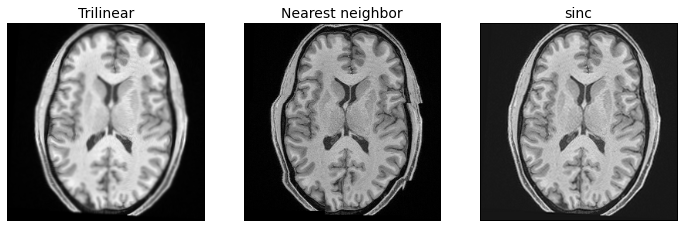

In [162]:
fig=plt.figure(figsize=(12,6))
plt.subplot()
labels=['Trilinear','Nearest neighbor','sinc']
interps=['trilinear','nearestneighbour','sinc']
for i in range(len(interps)):
    interp=interps[i]
    img=nibabel.load('/tmp/rotation_%s_5.nii.gz'%interp).get_data()
    
    
    plt.subplot(1,3,i+1)
    plt.imshow(numpy.rot90(img[:,:,150]),cmap='gray')
    plt.title(labels[i],fontsize=14)
    plt.xticks([])
    plt.yticks([])
    
plt.savefig(os.path.join(figuredir,'Figure_2_9.svg'),format='svg',dpi=1200)

__Figure 2.10__: use manually generated version from previous edition

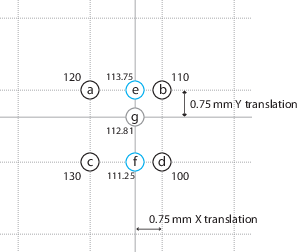

In [14]:
WImage(filename='/Users/poldrack/Dropbox/Documents/Books/HandbookOfFMRIAnalysis/fmri-handbook-2e/figures/Figure_2_10.pdf')

__Figure 2.11__: Example of sinc function

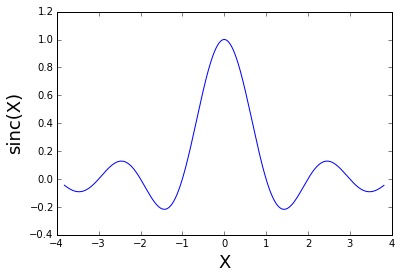

In [15]:
x=numpy.arange(-12,12,0.01)
sincx=sin(x)/x
plt.plot(x/numpy.pi,sincx)
plt.xlabel('X',fontsize=18)
plt.ylabel('sinc(X)',fontsize=18)
plt.savefig(os.path.join(figuredir,'Figure_2_11.svg'),format='svg',dpi=1200)

 __Figure 2.12__: Examples of filtering

In [25]:
%%R

noise=array(data=0,dim=1000)
arcoef=0.4

noise[1]=rnorm(1)
for (x in 2:1000) {
        noise[x]=noise[x-1]*arcoef + rnorm(1)
        }

foo=noise
foo=foo-mean(foo)

s=spectrum(foo,plot=FALSE)
foo.lo=loess(foo~c(1:1000),span=0.02)
sl=spectrum(foo.lo$fitted,plot=FALSE)
foo.hi=foo-foo.lo$fitted
sh=spectrum(foo.hi,plot=FALSE)

pdf('../figures/Figure_2_12.pdf')
layout(matrix(c(1:6),3,2,byrow=TRUE))
plot(foo[1:100],type='l',xlab="Time",ylab="Value",ylim=c(-3,3),main="Original data")
plot(s$freq,s$spec,type='l',xlab="Frequency",ylab="Power",ylim=c(0,12))

plot(foo.lo$fitted[1:100],type='l',xlab="Time",ylab="Value",ylim=c(-3,3),main="Low pass filtered")
plot(sl$freq,sl$spec,type='l',xlab="Frequency",ylab="Power",ylim=c(0,12))

plot(foo.hi[1:100],type='l',xlab="Time",ylab="Value",ylim=c(-3,3),main="High pass filtered")
plot(sh$freq,sh$spec,type='l',xlab="Frequency",ylab="Power",ylim=c(0,12))
dev.off()

quartz_off_screen 
                4 


__Figure 2.13__: Example of high-pass/low-pass filtering.

In [96]:
t1img=nibabel.load(data['T1_bc'])
t1data=t1img.get_data()
smoothed_t1=nilearn.image.smooth_img(t1img,12)
smoothed_data=smoothed_t1.get_data()
hpf_data=t1data - smoothed_data


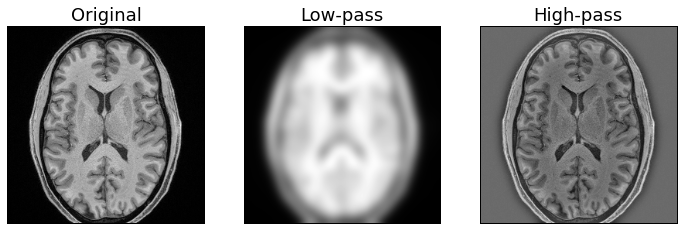

In [101]:
slicenum=150
fig=plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Original',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.imshow(numpy.rot90(t1data[:,:,slicenum]),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(numpy.rot90(smoothed_data[:,:,slicenum]),cmap='gray')
plt.title('Low-pass',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(numpy.rot90(hpf_data[:,:,slicenum]),cmap='gray')
plt.title('High-pass',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(figuredir,'Figure_2_13.svg'),format='svg',dpi=1200)

__Figure 2.14__: Example of convolution

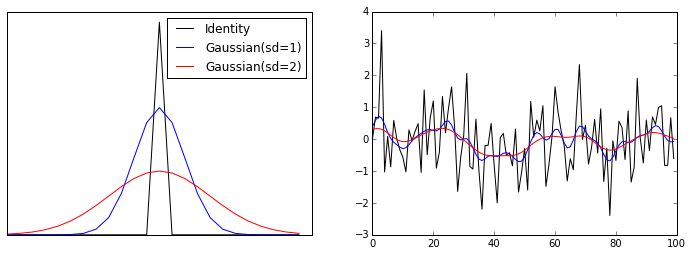

In [51]:
randsignal=numpy.random.randn(100)

pdfrange=numpy.arange(-6,6,0.5)
norm1=scipy.stats.norm.pdf(pdfrange,loc=0,scale=1.0)
norm1=norm1/float(numpy.sum(norm1))
norm2=scipy.stats.norm.pdf(pdfrange,loc=0,scale=2.0)
norm2=norm2/float(numpy.sum(norm2))
ident=numpy.zeros(norm1.shape)
ident[ident.shape[0]/2]=1

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(pdfrange,ident/3.,color='black')
plt.plot(pdfrange,norm1,color='blue')
plt.plot(pdfrange,norm2,color='red')
plt.yticks([])
plt.xticks([])
plt.legend(['Identity','Gaussian(sd=1)','Gaussian(sd=2)'])
plt.subplot(1,2,2)
#plt.plot(randsignal)
idconv=numpy.convolve(randsignal,ident,mode='same')
plt.plot(idconv,color='black')
norm1conv=numpy.convolve(randsignal,norm1,mode='same')
plt.plot(norm1conv,color='blue')
norm2conv=numpy.convolve(randsignal,norm2,mode='same')
plt.plot(norm2conv,color='red')
plt.savefig(os.path.join(figuredir,'Figure_2_14.svg'),format='svg',dpi=1200)